In [631]:
# IMPORTS

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import power_transform, MinMaxScaler, StandardScaler
import numpy as np
import pickle as pkl

In [632]:
# Read 1 and format date
df = pd.read_csv('RV1_SIPIA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.drop(['Latitude', 'Longitude', 'Altitude'], axis=1, inplace=True)
df.head(8)

,Date,NO2,PM2.5,O3,PM10
42,2023-02-15 19:35:00+00:00,70.0,71.0,NaN,90.0
57,2023-02-15 20:15:00+00:00,56.0,76.0,2.0,86.0
55,2023-02-15 20:35:00+00:00,56.0,76.0,2.0,86.0
95,2023-02-15 21:15:00+00:00,48.0,73.0,2.0,78.0
88,2023-02-15 21:35:00+00:00,48.0,73.0,2.0,78.0
48,2023-02-15 22:15:00+00:00,44.0,84.0,2.0,89.0
49,2023-02-15 22:35:00+00:00,44.0,84.0,2.0,89.0
93,2023-02-15 23:15:00+00:00,34.0,75.0,2.0,78.0


In [633]:
df.set_index('Date').head(10)

,NO2,PM2.5,O3,PM10
Date,,,,
2023-02-15 19:35:00+00:00,70.0,71.0,NaN,90.0
2023-02-15 20:15:00+00:00,56.0,76.0,2.0,86.0
2023-02-15 20:35:00+00:00,56.0,76.0,2.0,86.0
2023-02-15 21:15:00+00:00,48.0,73.0,2.0,78.0
2023-02-15 21:35:00+00:00,48.0,73.0,2.0,78.0
2023-02-15 22:15:00+00:00,44.0,84.0,2.0,89.0
2023-02-15 22:35:00+00:00,44.0,84.0,2.0,89.0
2023-02-15 23:15:00+00:00,34.0,75.0,2.0,78.0
2023-02-15 23:35:00+00:00,34.0,75.0,2.0,78.0


In [634]:
# Read 2 and format date
df2 = pd.read_csv('open-meteo-46.22N15.36E239m.csv')
df2['Date'] = pd.to_datetime(df2['time'], errors='coerce', infer_datetime_format=True).dt.tz_localize('UTC')
df2.drop(['time'], axis=1, inplace=True)
df2

C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_10388\871714293.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df2['Date'] = pd.to_datetime(df2['time'], errors='coerce', infer_datetime_format=True).dt.tz_localize('UTC')


,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),pressure_msl (hPa),surface_pressure (hPa),Date
0,0.8,89,-0.7,-1.8,0.00,1036.2,1005.9,2023-02-15 00:00:00+00:00
1,0.2,93,-0.9,-2.6,0.00,1035.9,1005.5,2023-02-15 01:00:00+00:00
2,-0.3,96,-0.9,-2.8,0.00,1035.8,1005.4,2023-02-15 02:00:00+00:00
3,-1.5,99,-1.6,-4.1,0.00,1035.4,1004.8,2023-02-15 03:00:00+00:00
4,-3.0,99,-3.2,-6.0,0.00,1034.9,1004.2,2023-02-15 04:00:00+00:00
...,...,...,...,...,...,...,...,...
7496,6.8,-2.5,1.0,4.0,-5.8,-2.1,0.00,NaT
7497,3.9,-3.1,-0.2,1.7,-6.3,-3.1,0.00,NaT
7498,4.1,-3.0,0.2,1.4,-6.3,-2.6,1.70,NaT
7499,8.1,-1.2,2.5,5.3,-4.2,-0.7,3.40,NaT


In [635]:
df['Date'] = df['Date'].dt.floor('h')
df2['Date'] = df2['Date'].dt.floor('h')

df = pd.merge(df, df2, on='Date', how='inner')
df.set_index('Date', inplace=True)

In [636]:
newColumns = [
    'temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
    'apparent_temperature (°C)', 'precipitation (mm)', 'pressure_msl (hPa)',
    'surface_pressure (hPa)'
]
for column in newColumns:
    df2[column] = df2[column].replace('[^\d\.-]', '', regex=True)
    df2[column] = pd.to_numeric(df2[column], errors='coerce')
    
for column in newColumns:
    df2[column] = df2[column].replace('[^\d\.-]', '', regex=True)
    df2[column] = df2[column].astype('float64')

In [637]:
df.dtypes

NO2                          float64
PM2.5                        float64
O3                           float64
PM10                         float64
temperature_2m (°C)           object
relative_humidity_2m (%)      object
dew_point_2m (°C)             object
apparent_temperature (°C)     object
precipitation (mm)            object
pressure_msl (hPa)            object
surface_pressure (hPa)        object
dtype: object

In [638]:
print(f'{df.index.min()} - {df.index.max()}')
dateRange = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missingDates = dateRange.difference(df.index)

print(missingDates)
print(f'{len(missingDates)} missing dates')

2023-02-15 19:00:00+00:00 - 2023-12-11 08:00:00+00:00
DatetimeIndex(['2023-03-17 19:00:00+00:00', '2023-03-18 19:00:00+00:00',
               '2023-03-19 19:00:00+00:00', '2023-03-20 19:00:00+00:00',
               '2023-03-21 19:00:00+00:00', '2023-03-22 19:00:00+00:00',
               '2023-03-23 19:00:00+00:00', '2023-03-24 19:00:00+00:00',
               '2023-03-25 19:00:00+00:00', '2023-03-26 19:00:00+00:00',
               '2023-03-27 19:00:00+00:00', '2023-03-28 19:00:00+00:00',
               '2023-03-29 19:00:00+00:00', '2023-03-30 19:00:00+00:00',
               '2023-03-31 19:00:00+00:00', '2023-04-01 19:00:00+00:00',
               '2023-04-02 19:00:00+00:00', '2023-04-03 19:00:00+00:00',
               '2023-04-04 19:00:00+00:00', '2023-04-05 19:00:00+00:00',
               '2023-04-06 19:00:00+00:00', '2023-04-07 19:00:00+00:00',
               '2023-04-08 19:00:00+00:00', '2023-04-09 19:00:00+00:00',
               '2023-04-10 19:00:00+00:00', '2023-04-11 19:00:00+00:00

In [639]:
df.isna().sum()

NO2                          402
PM2.5                         67
O3                           297
PM10                          67
temperature_2m (°C)            0
relative_humidity_2m (%)       0
dew_point_2m (°C)              0
apparent_temperature (°C)      0
precipitation (mm)             0
pressure_msl (hPa)             0
surface_pressure (hPa)         0
dtype: int64

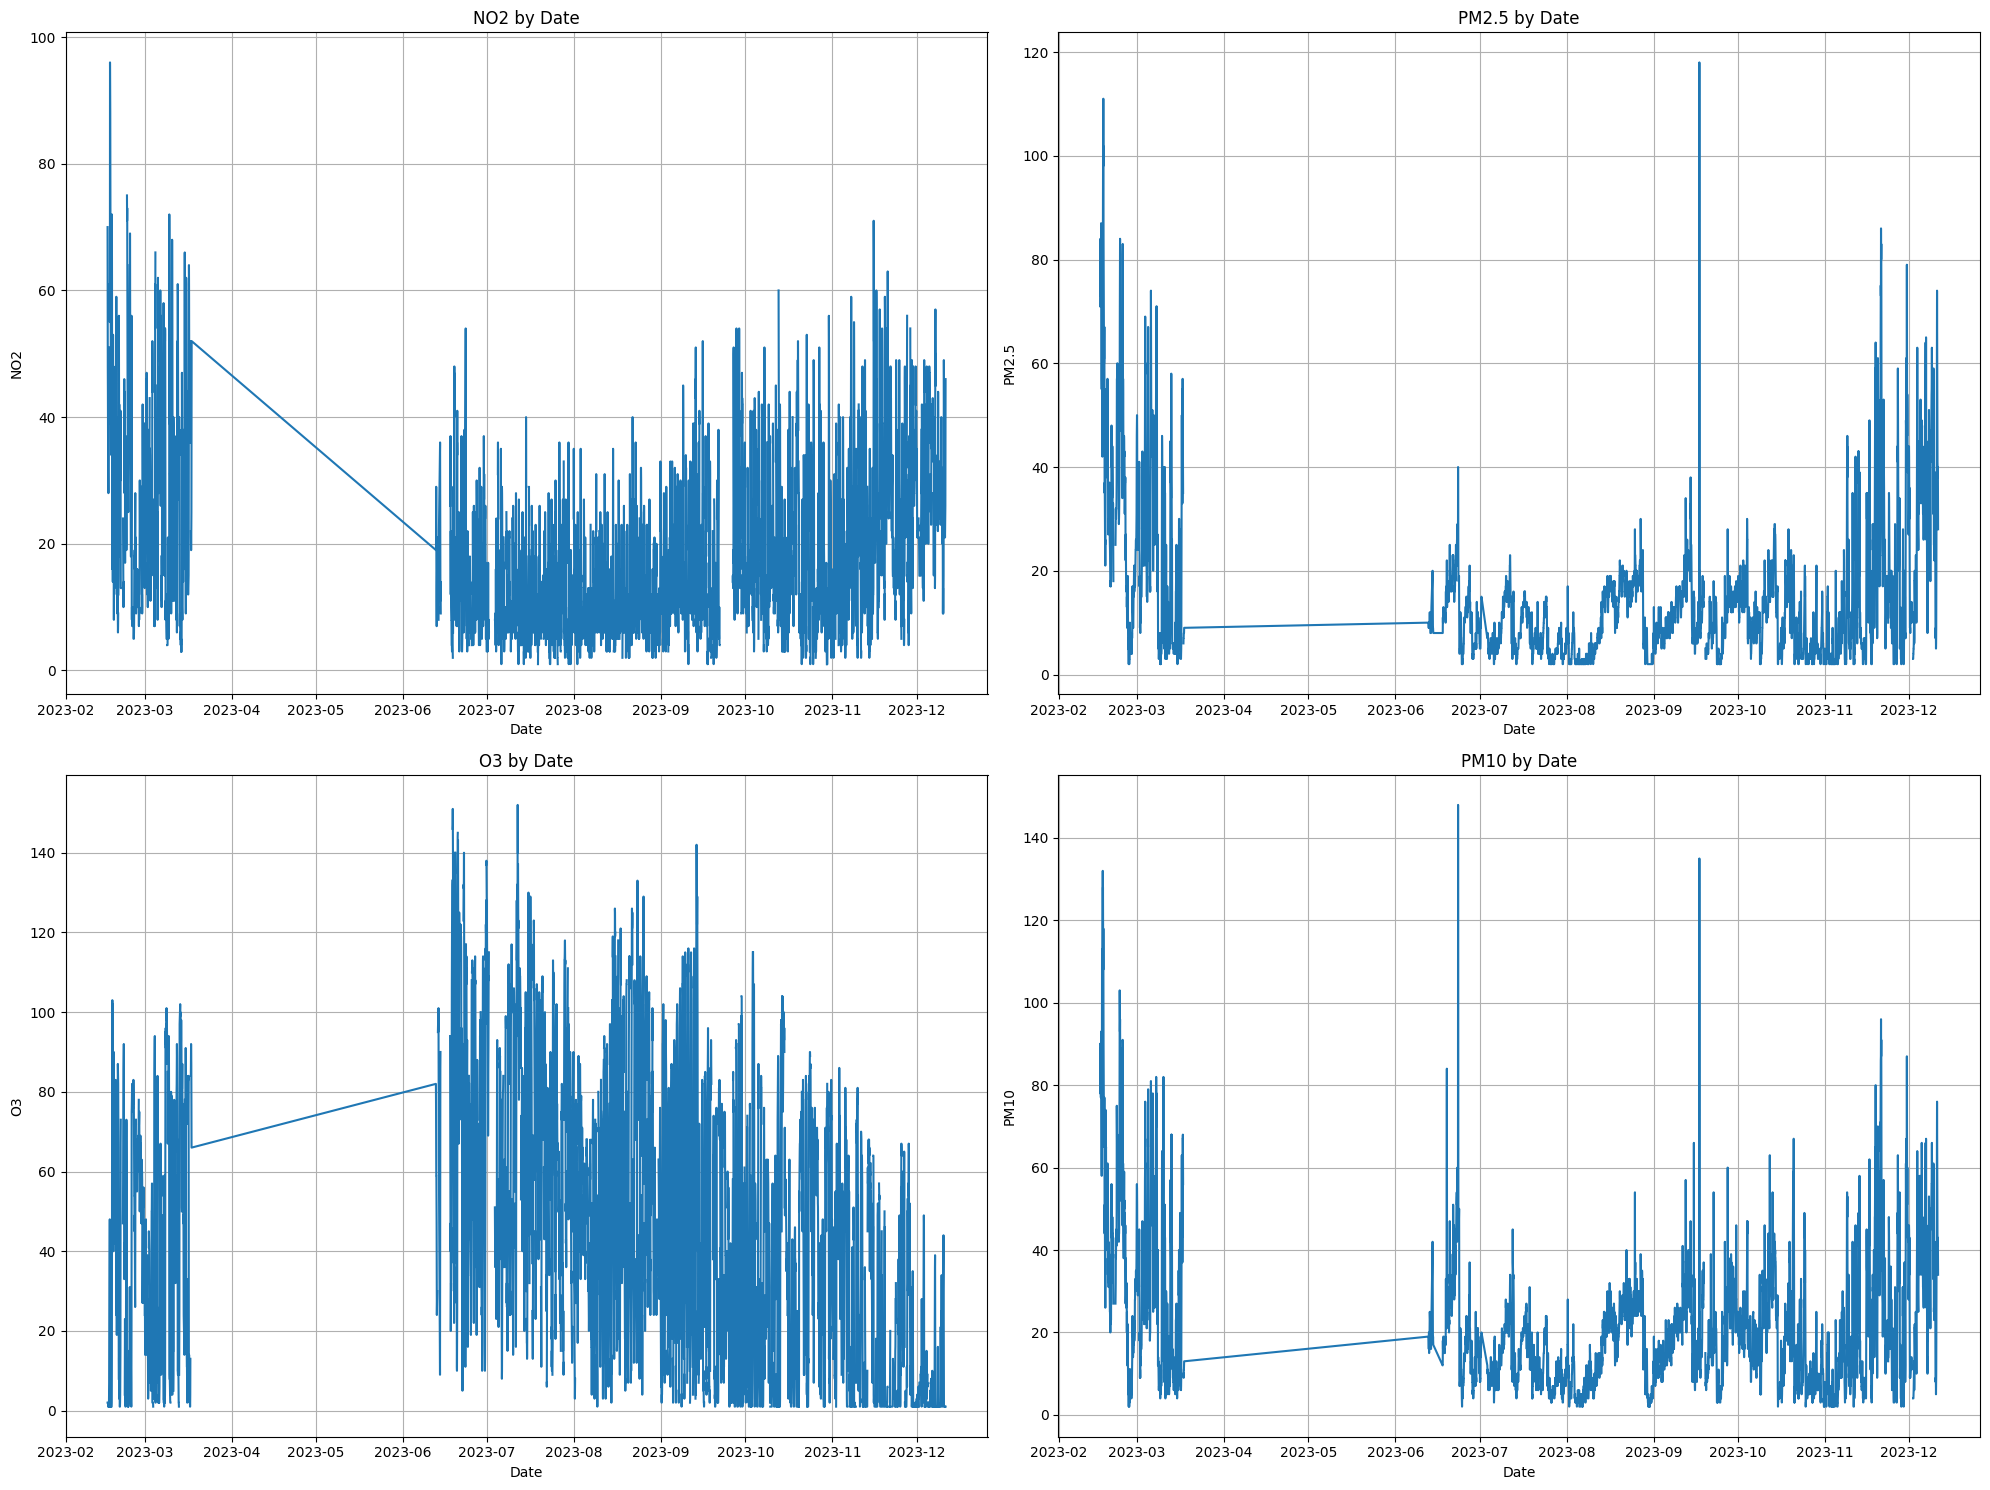

In [640]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 15))
axes = axes.flatten()
for i, column in enumerate(["NO2", "PM2.5", "O3", "PM10"]):
    axes[i].plot(df.index, df[column])
    axes[i].set_title(f'{column} by Date')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [641]:
df.describe()

,NO2,PM2.5,O3,PM10
count,5223.000000,5558.000000,5328.000000,5558.000000
mean,19.042313,16.507377,44.400901,22.906441
std,13.622852,15.597033,34.448438,18.265637
min,1.000000,2.000000,1.000000,2.000000
25%,9.000000,6.000000,11.000000,10.000000
50%,15.000000,12.000000,41.000000,18.000000
75%,26.000000,20.000000,71.000000,30.000000
max,96.000000,118.000000,152.000000,148.000000


In [642]:
nanCols = ['NO2', 'PM2.5', 'O3', 'PM10']
imputer = SimpleImputer(strategy='mean')

for column in nanCols:
    X = df.drop(columns=[column])
    Xfilled = imputer.fit_transform(X)
    
    y = df[column]
    
    Xtrain = Xfilled[y.notna()]
    yTrain = y[y.notna()]
    Xpred = Xfilled[y.isna()]
    
    rfr = RandomForestRegressor(n_estimators=100, random_state=0)
    rfr.fit(Xtrain, yTrain)
    preds = rfr.predict(Xpred)
    
    df.loc[df[column].isna(), column] = preds

In [643]:
df.isna().sum()

NO2                          0
PM2.5                        0
O3                           0
PM10                         0
temperature_2m (°C)          0
relative_humidity_2m (%)     0
dew_point_2m (°C)            0
apparent_temperature (°C)    0
precipitation (mm)           0
pressure_msl (hPa)           0
surface_pressure (hPa)       0
dtype: int64

In [644]:
def plotDistributions(df, ncols=4):
    columns = df.columns
    ncols = ncols
    nrows = (len(columns) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4))

    if nrows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for i, column in enumerate(columns):
        ax = axes[i]
        ax.hist(df[column].dropna(), bins=20, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

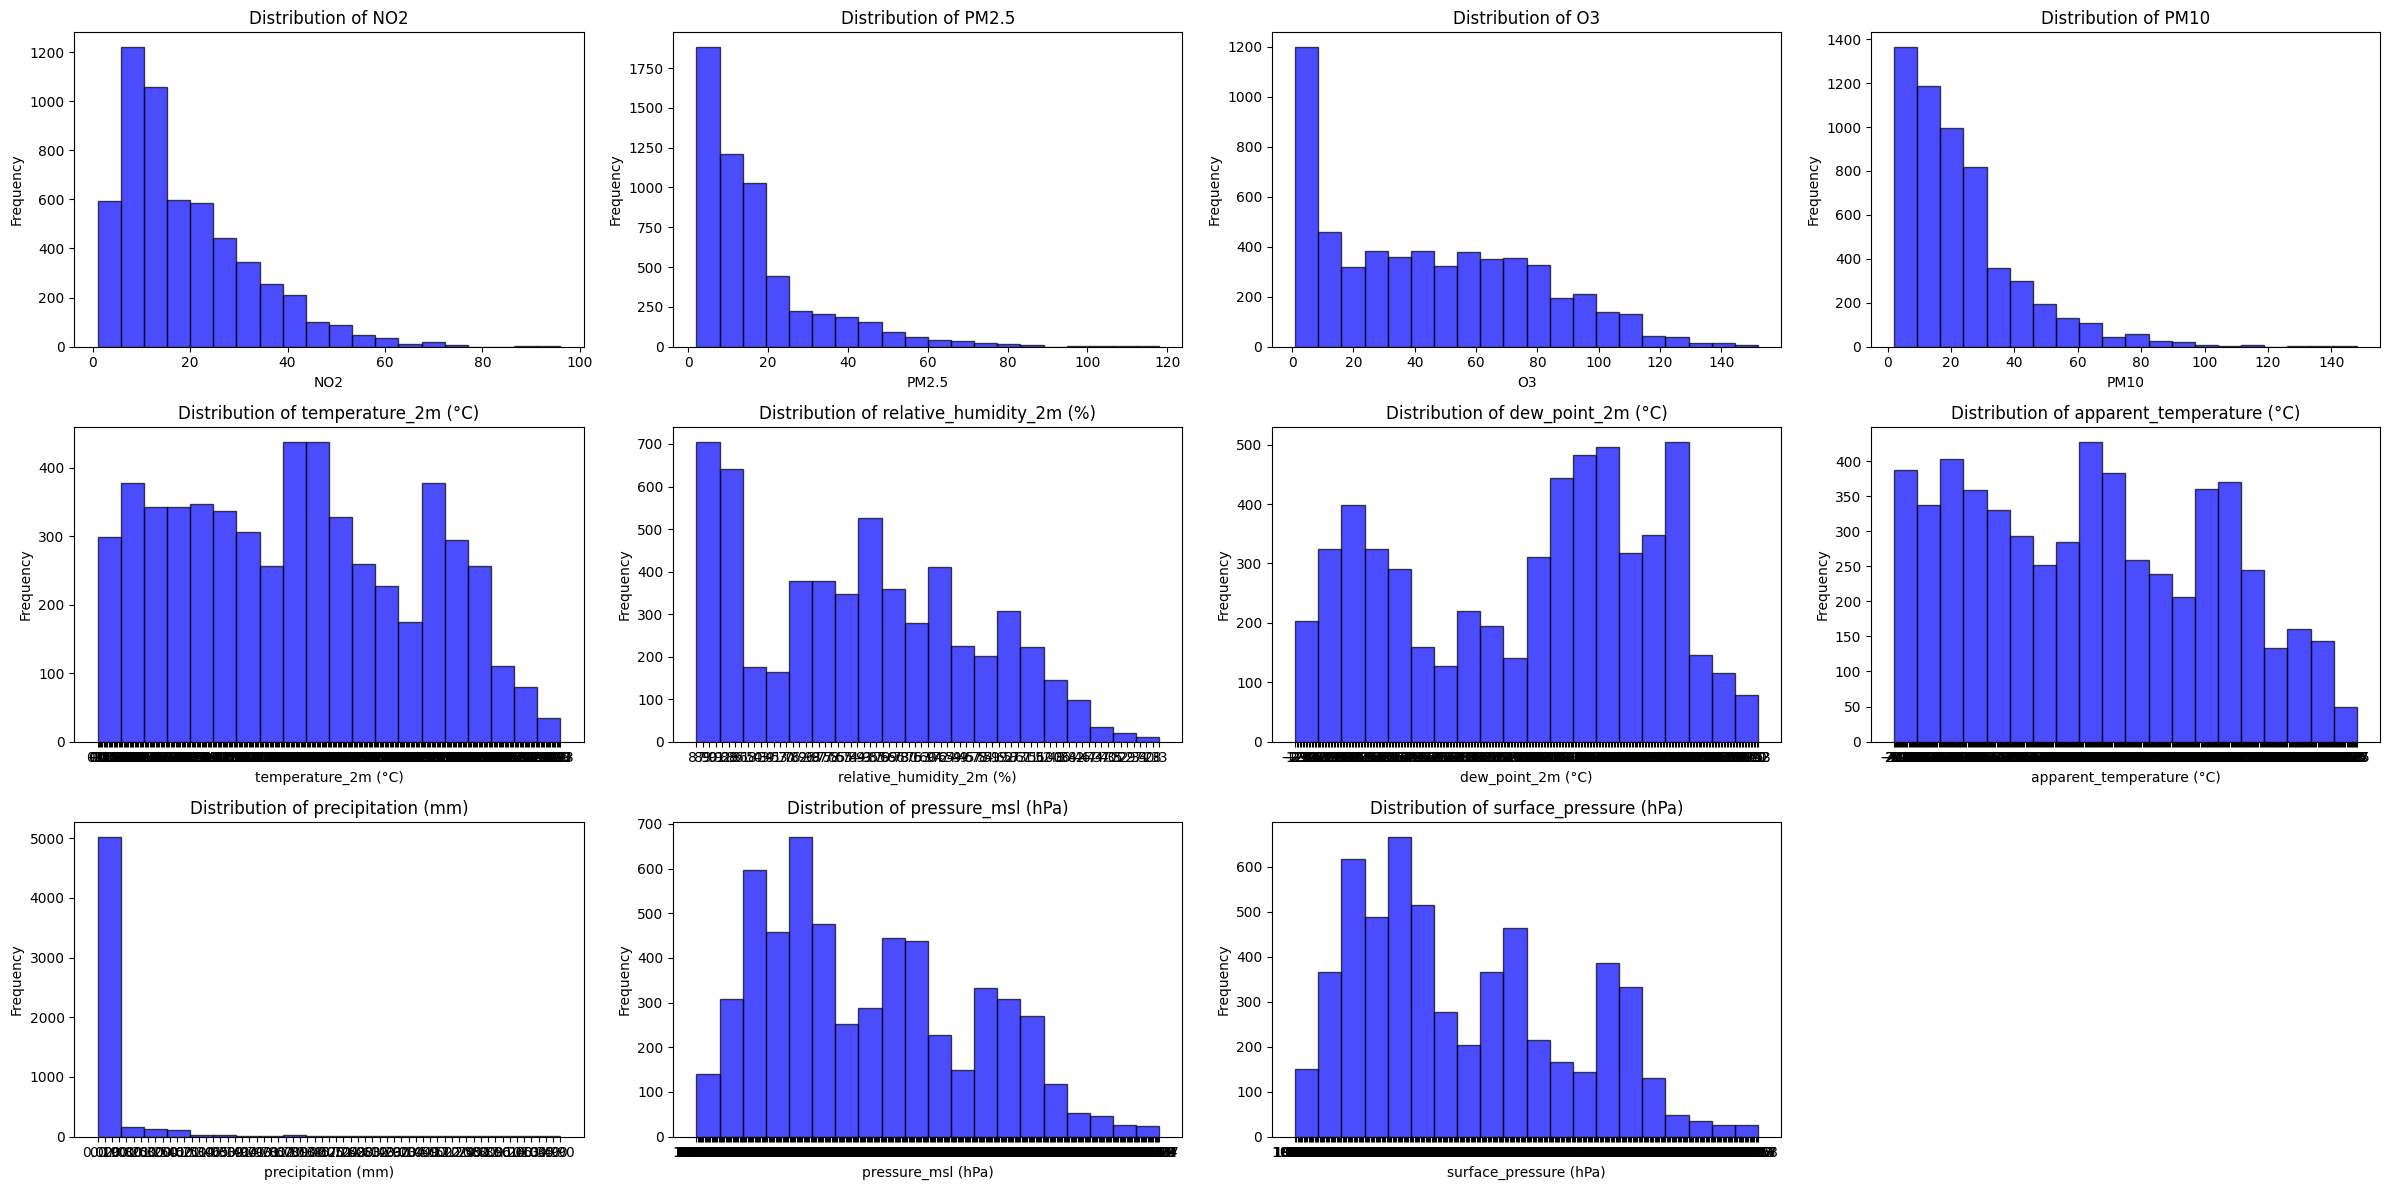

In [645]:
plotDistributions(df=df, ncols=4)

In [646]:
for column in df.columns:
    df[column] = power_transform(df[[column]].values, method='yeo-johnson')

D:\Projects\rirsu-rnn\venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
D:\Projects\rirsu-rnn\venv\Lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


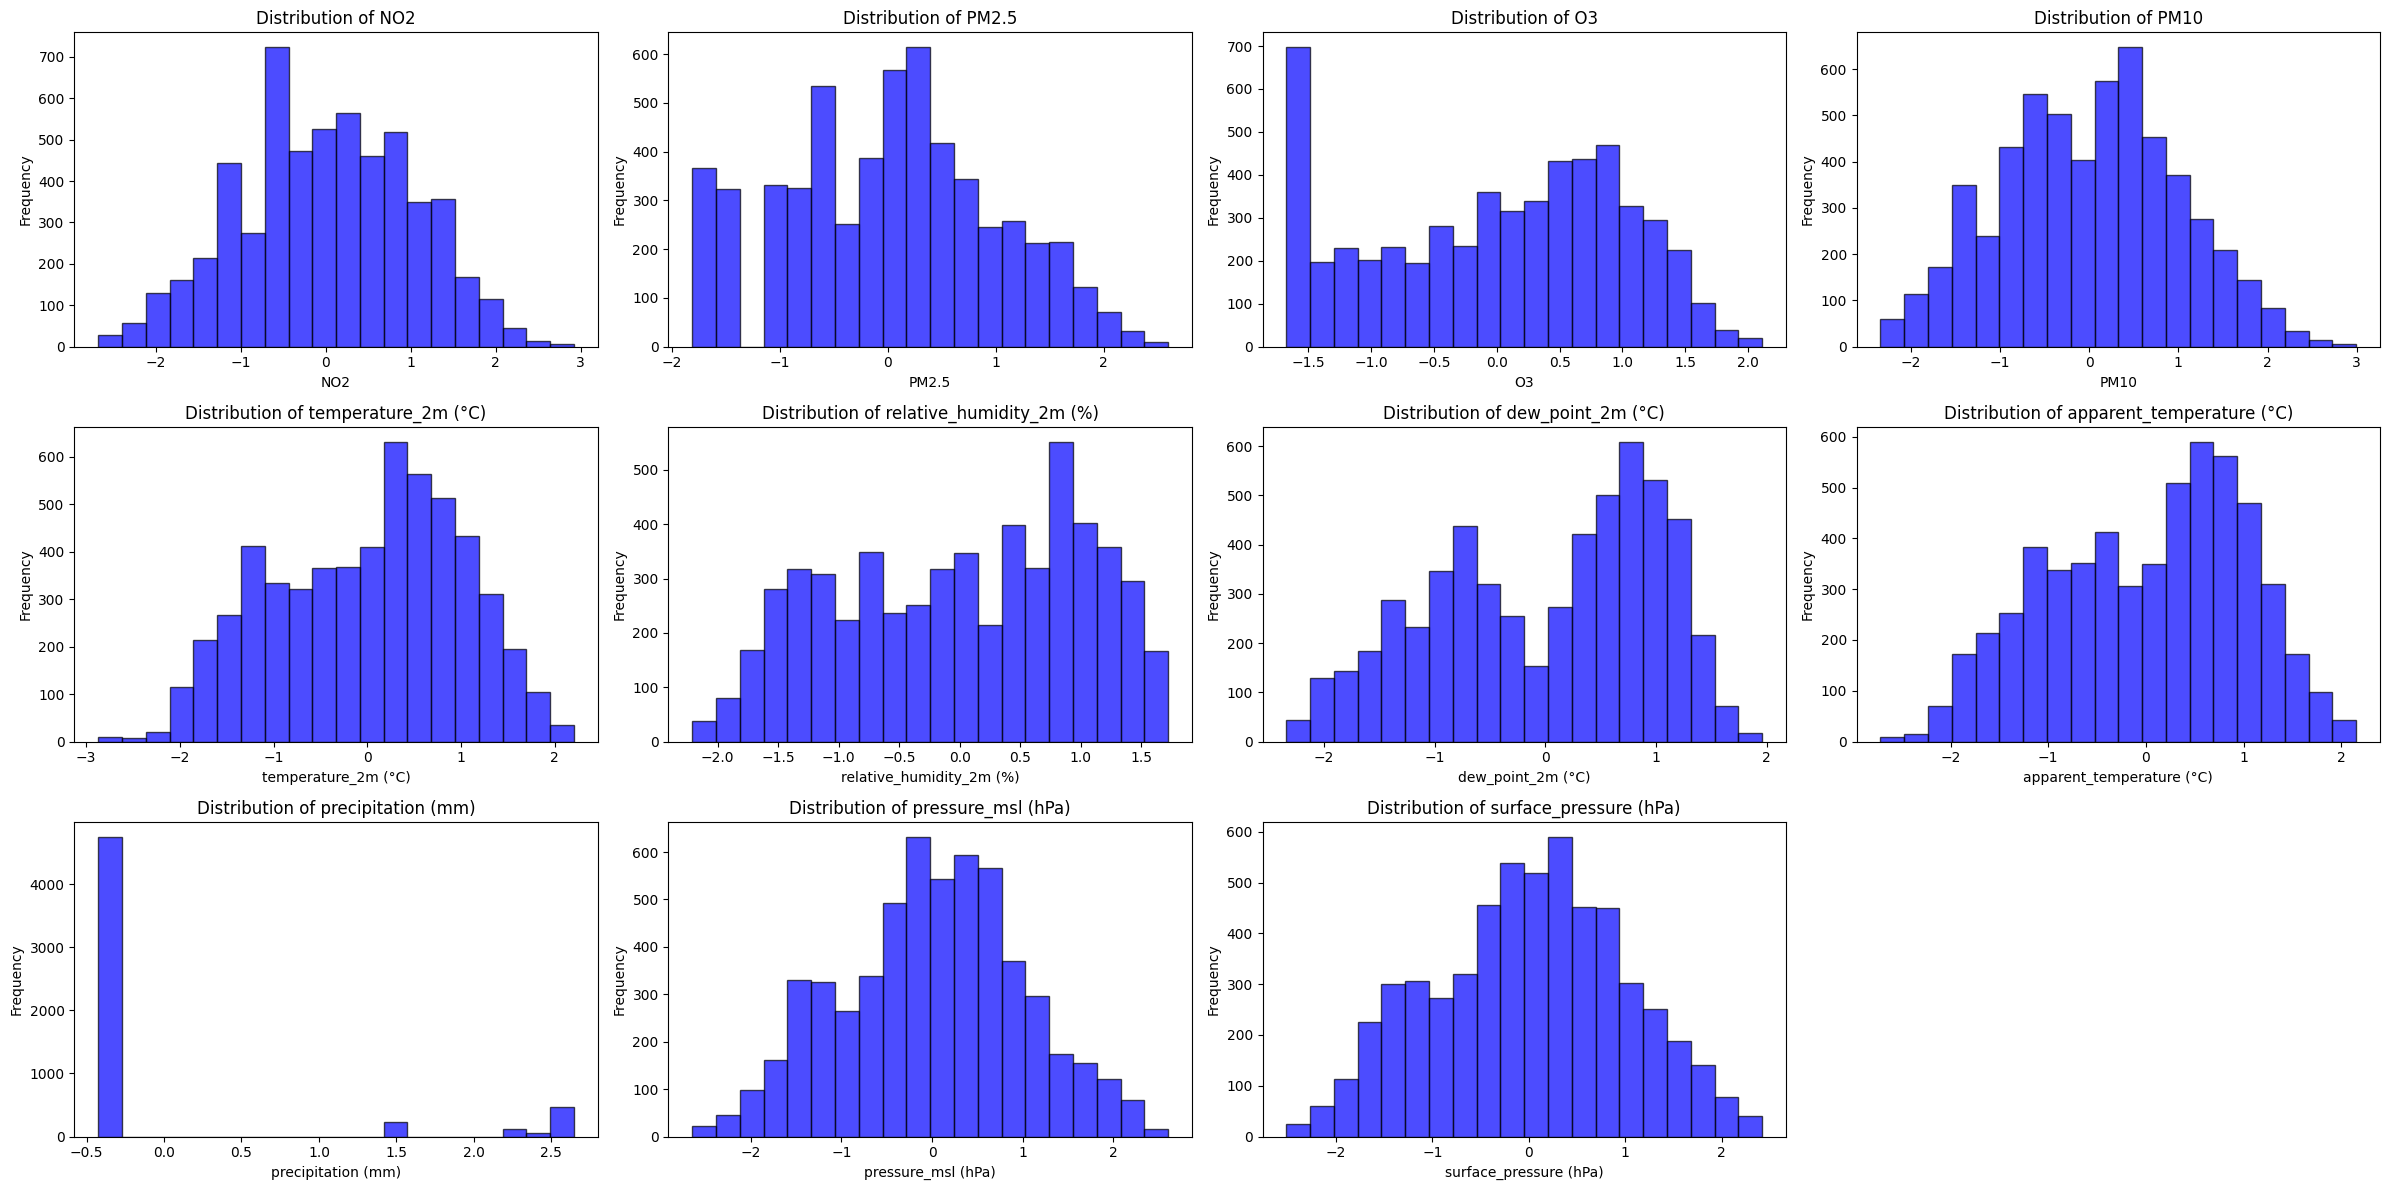

In [647]:
plotDistributions(df=df, ncols=4)

In [648]:
mms = MinMaxScaler()
std = StandardScaler()

df[['PM2.5', 'O3', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)']] = mms.fit_transform(df[['PM2.5', 'O3', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)']])
df[['NO2', 'PM10', 'temperature_2m (°C)', 'pressure_msl (hPa)', 'surface_pressure (hPa)']] = std.fit_transform(df[['NO2', 'PM10', 'temperature_2m (°C)', 'pressure_msl (hPa)', 'surface_pressure (hPa)']])

In [649]:
# Lagged Features for NO2 (lag of 1 day)
df['lag1_NO2'] = df['NO2'].shift(1)

# Rolling Window Statistics for PM10 (rolling mean over 7 days)
df['roll_mean_PM10_7d'] = df['PM10'].rolling(window=7).mean()

# Change in PM2.5 from the previous measurement
df['diff_PM2.5'] = df['PM2.5'].diff()

# Cumulative Count of high NO2 days (above a certain threshold, e.g., 75th percentile)
threshold_NO2 = df['NO2'].quantile(0.75)
df['cum_count_high_NO2'] = (df['NO2'] > threshold_NO2).cumsum()

# Interaction term between NO2 and O3
df['NO2_O3_interaction'] = df['NO2'] * df['O3']

# Square of PM2.5
df['PM2.5_squared'] = df['PM2.5'] ** 2

df['O3_quartile'] = pd.qcut(df['O3'], q=4, labels=False)

# Rolling Variance of PM2.5 over a 7-day window
df['roll_var_PM2.5_7d'] = df['PM2.5'].rolling(window=7).var()

# Difference for PM10
df['diff_PM10'] = df['PM10'].diff()


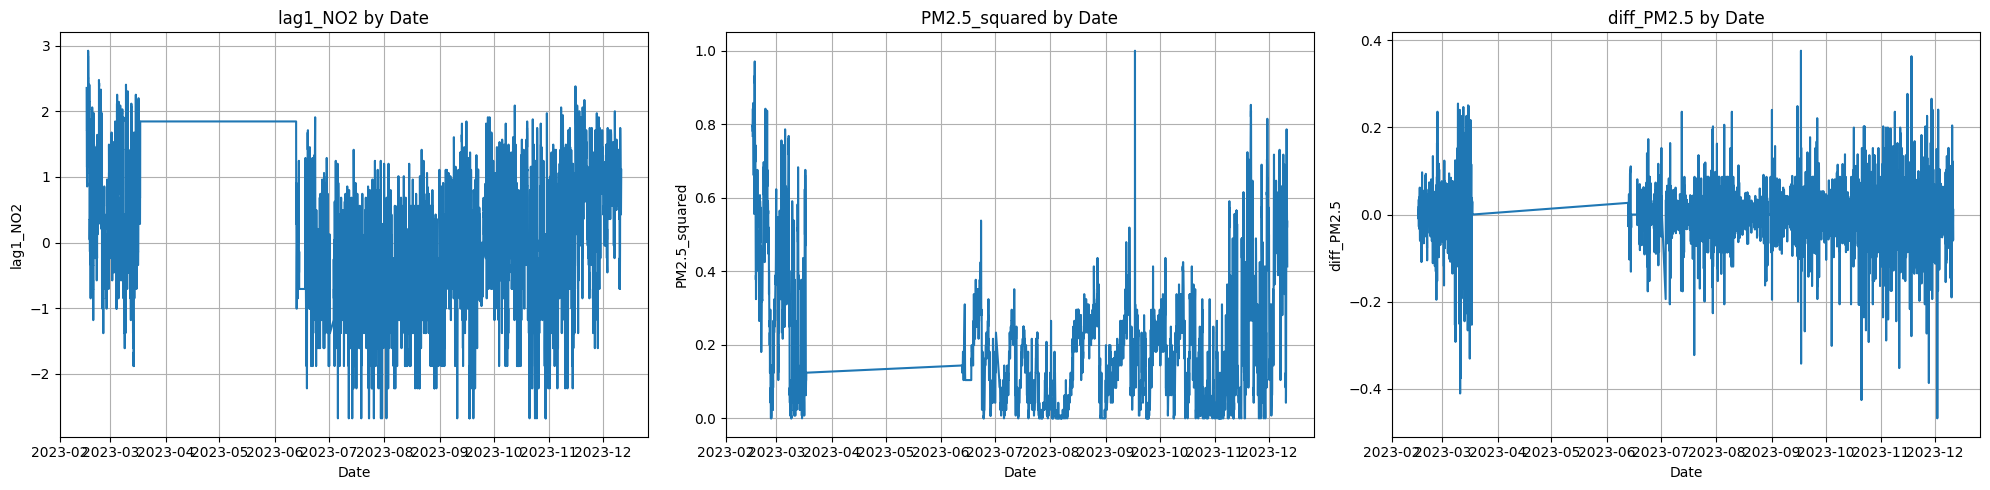

In [650]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes = axes.flatten()
for i, column in enumerate(['lag1_NO2', 'PM2.5_squared', 'diff_PM2.5']):
    axes[i].plot(df.index, df[column])
    axes[i].set_title(f'{column} by Date')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_10388\2400267053.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


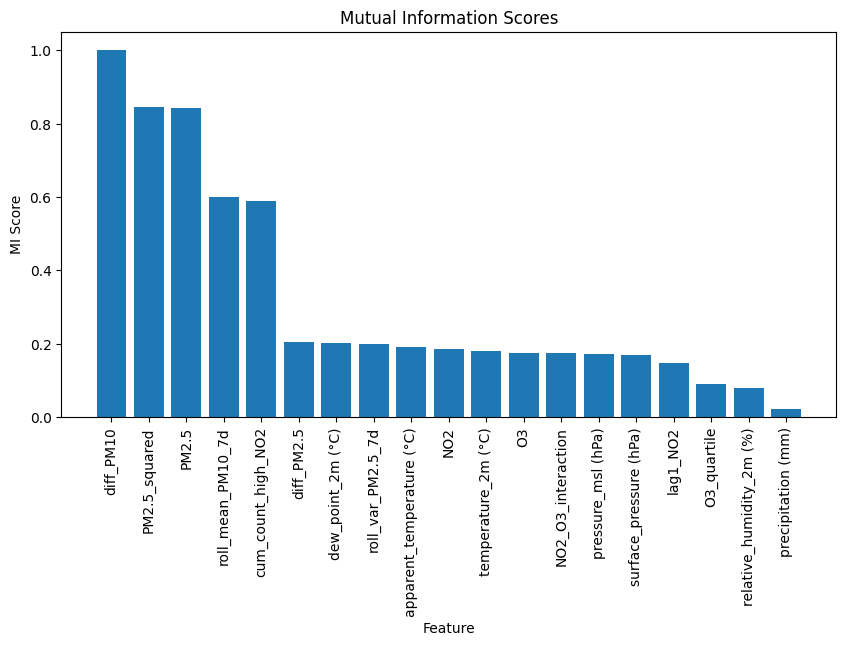

In [651]:
# To fill NaN created by lagging and differencing
df.fillna(method='bfill', inplace=True)

X = df.drop(['PM10'], axis=1)
y = df['PM10']

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

miDf = pd.DataFrame({'feature': X.columns, 'mi': mi}).sort_values(by='mi', ascending=False)
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(miDf['feature'], miDf['mi'])
ax.set_title('Mutual Information Scores')
ax.set_xlabel('Feature')
ax.set_ylabel('MI Score')
plt.xticks(rotation=90)
plt.show()

In [652]:
selectedFeatures = miDf.loc[miDf['mi'] >= 0.2, 'feature'].values
df[[*selectedFeatures, 'PM10']].tail()

,diff_PM10,PM2.5_squared,PM2.5,roll_mean_PM10_7d,cum_count_high_NO2,diff_PM2.5,dew_point_2m (°C),PM10
Date,,,,,,,,
2023-12-11 04:00:00+00:00,0.000000,0.537894,0.733412,1.531619,1381,-0.006224,0.289087,1.154440
2023-12-11 05:00:00+00:00,-0.033477,0.519070,0.720465,1.438518,1381,-0.012947,0.295191,1.120962
2023-12-11 06:00:00+00:00,0.066232,0.537894,0.733412,1.322524,1381,0.012947,0.301307,1.187195
2023-12-11 07:00:00+00:00,-0.208076,0.489524,0.699660,1.202918,1382,-0.033752,0.341301,0.979118
2023-12-11 08:00:00+00:00,-0.115893,0.413376,0.642943,1.118510,1383,-0.056717,0.366081,0.863226


In [653]:
df[[*selectedFeatures, 'PM10']].to_csv('RV1_SIPIA_preprocessed.csv')

In [654]:
with open('scaling/std-scaler.pkl', 'wb') as f:
    pkl.dump(std, f)
    
with open('scaling/mms-scaler.pkl', 'wb') as f:
    pkl.dump(mms, f)